<a href="https://colab.research.google.com/github/haimin777/tools/blob/master/CheckPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.3.0
!pip install -U git+https://github.com/haimin777/keras-ocr.git
!pip install -U opencv-python # We need the most recent version of OpenCV.
 
!pip install tensorflow-addons==0.11.2
 
%tensorflow_version 2.x
from IPython.display import clear_output
clear_output()

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 


In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os
import shutil as sh
 
import typing
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow as tf
import sklearn.model_selection
 
from tensorflow import keras
import keras_ocr
import numpy as np
import pandas as pd
 
from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from numpy import array
 
import cv2
from PIL import Image
#assert tf.test.is_gpu_available()
 
#import tensorflow_addons as tfa

In [ ]:
 
#import tools.qacheck as qacheck
keras_ocr.tools.initialize_image_ops()

In [5]:
# Check test files
 
if not os.path.exists('GGPokerOk_GT_3_cat'):
 
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AhIIy_Oeu7AXGnN_mvwKGAvBGEk7cxsu' -O GGPokerOk_GT_3_cat.zip
    !unzip -q GGPokerOk_GT_3_cat.zip

--2021-01-14 07:11:49--  https://docs.google.com/uc?export=download&id=1AhIIy_Oeu7AXGnN_mvwKGAvBGEk7cxsu
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.113, 108.177.126.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/emjbj0ui1o9finaepd78dsjntlnmrj0h/1610608275000/08605806127936840926/*/1AhIIy_Oeu7AXGnN_mvwKGAvBGEk7cxsu?e=download [following]
--2021-01-14 07:11:51--  https://doc-0s-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/emjbj0ui1o9finaepd78dsjntlnmrj0h/1610608275000/08605806127936840926/*/1AhIIy_Oeu7AXGnN_mvwKGAvBGEk7cxsu?e=download
Resolving doc-0s-4o-docs.googleusercontent.com (doc-0s-4o-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-0s-4o-docs.googleusercontent.com (doc-0s

In [6]:
# download backbone weights

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L7j9tUKmalOS02411ob58UW1isNtDWFh' -O craft_mlt_25k.h5
!mkdir /root/.keras-ocr 
!mv craft_mlt_25k.h5 /root/.keras-ocr


--2021-01-14 07:11:58--  https://docs.google.com/uc?export=download&id=1L7j9tUKmalOS02411ob58UW1isNtDWFh
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.113, 108.177.126.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m3m34873t450a2t6imi8qbs33nojb28r/1610608275000/08605806127936840926/*/1L7j9tUKmalOS02411ob58UW1isNtDWFh?e=download [following]
--2021-01-14 07:12:01--  https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m3m34873t450a2t6imi8qbs33nojb28r/1610608275000/08605806127936840926/*/1L7j9tUKmalOS02411ob58UW1isNtDWFh?e=download
Resolving doc-08-4o-docs.googleusercontent.com (doc-08-4o-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-08-4o-docs.googleusercontent.com (doc-08

In [7]:
test_images_full = glob.glob('GGPokerOk_GT_3_cat/*jpg')
test_xmls = glob.glob('GGPokerOk_GT_3_cat/*xml')
 
test_xmls.sort()
test_images_full.sort()
test_images_full[:2], test_xmls[:2]

(['GGPokerOk_GT_3_cat/image0000000002.jpg',
  'GGPokerOk_GT_3_cat/image0000000195.jpg'],
 ['GGPokerOk_GT_3_cat/image0000000002.xml',
  'GGPokerOk_GT_3_cat/image0000000195.xml'])

In [17]:
# Paths to weights
#recognizer_weigths = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/re*-01-13T*.h5')  # - for recognizer check
recognizer_weigths = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/re*J_*T*.h5') 
 
#detect_weights = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/d*12-29T13:38*.h5') # - for recognizer check
detect_weights = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det*2021-01-14T*.h5')

detect_weights, recognizer_weigths

(['/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_AOls_colab2021-01-14T06:41:51.390557.h5',
  '/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_H_colab2021-01-14T06:54:59.180946.h5'],
 ['/content/drive/My Drive/AIgym/keras-ocr/trained_weights/rec_SynData_J_DigitsText_DigitsDoll_filtred_2020-11-13T09:42:34.756546.h5'])

In [18]:
#create model and load weights
 
alphabet = string.digits + string.ascii_letters + '$%./ ♥♠♦♣'  #'$%. '
 
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
 
#one_graph_model = one_graph_utils.create_one_grap_model(detect_weights[-1], recognizer_weigths[0], recognizer_alphabet)
one_graph_model = keras_ocr.tools.create_one_grap_model(detect_weights[-1], recognizer_weigths[-1], recognizer_alphabet)
clear_output()

In [19]:
  
one_graph_pipeline = keras_ocr.tools.OneGraphPipeline(one_graph_model, recognizer_alphabet)
 
qa_df_one = keras_ocr.tools.quality_df(test_images_full, test_xmls,  one_graph_pipeline, one_graph=True)
 
qa_df_one.describe()

,card_acc,card_recall,money_acc,money_recall,other_acc,other_recall
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.875882,0.213824,0.859412,0.319265,0.687059,0.182647
std,0.207639,0.168683,0.145621,0.124040,0.114710,0.081582
min,0.000000,0.000000,0.430000,0.000000,0.420000,0.060000
25%,0.822500,0.112500,0.817500,0.220000,0.590000,0.110000
50%,1.000000,0.220000,0.890000,0.330000,0.710000,0.170000
75%,1.000000,0.290000,1.000000,0.380000,0.790000,0.240000
max,1.000000,1.000000,1.000000,0.570000,0.870000,0.380000


In [18]:
# print ids of images with minimal cards accuracy
qa_df_one[qa_df_one['card_acc'] == 0.33]

,image_name,card_acc,card_recall,money_acc,money_recall,other_acc,other_recall
31,image0000001082.xml,0.33,0.5,0.62,0.29,0.38,0.36


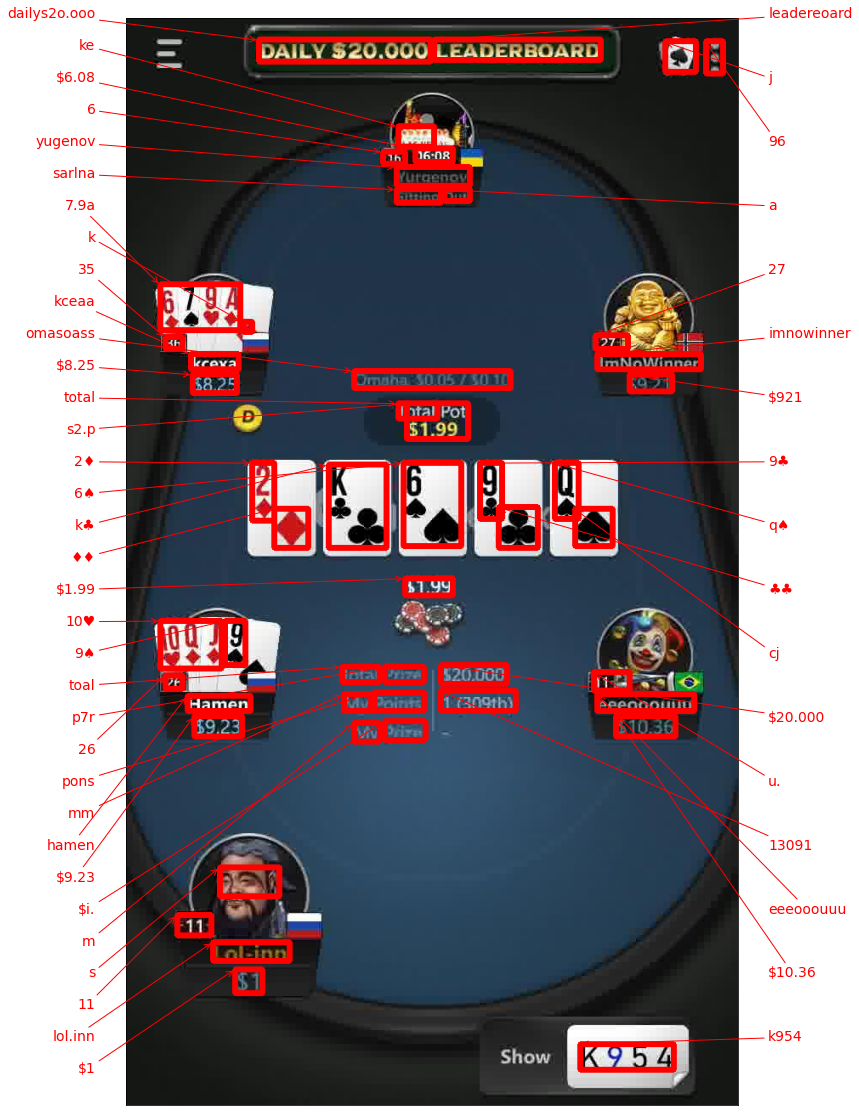

In [20]:
# wisualize given results for some ids
n = 41
inp = keras_ocr.tools.read(test_images_full[n]) 
img = inp
inp = np.expand_dims(inp, 0)
prediction_groups_one = one_graph_pipeline.recognize(inp)
fig, axs = plt.subplots(nrows=1, figsize=(20, 20))
keras_ocr.tools.drawAnnotations(img, predictions=prediction_groups_one[0], ax=axs)

# Check results on train data

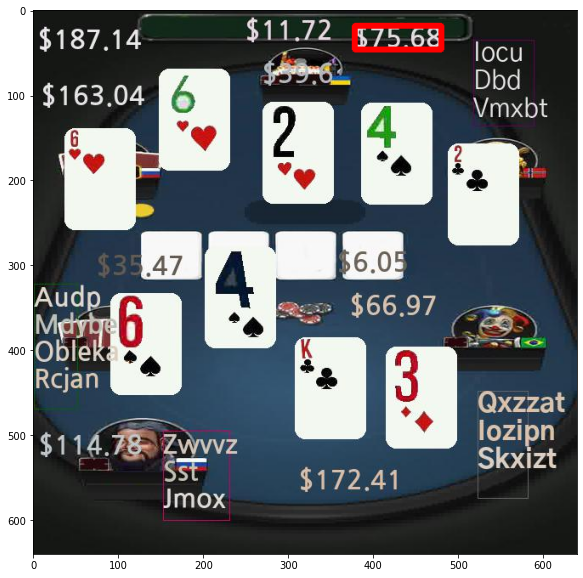

In [ ]:
train_images = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/datasetVin_cards_1k_2/*jpg')
n = 33
inp = keras_ocr.tools.read(train_images[n]) 
img = inp
inp = np.expand_dims(inp, 0)
prediction_groups_one = one_graph_pipeline.recognize(inp)

bboxes = [data[1] for data in prediction_groups_one]
plt.figure(figsize=(10,10))

canvas = keras_ocr.tools.drawBoxes(image=img, boxes=bboxes, boxes_format='predictions')
plt.imshow(canvas)


In [ ]:
det = keras_ocr.detection.Detector()
det.model.summary()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Model: "functional_223"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
basenet.slice1.0 (Conv2D)       (None, None, None, 6 1792        input_67[0][0]                   
__________________________________________________________________________________________________
basenet.slice1.1 (BatchNormaliz (None, None, None, 6 256         basenet.slice1.0[0][0]           
__________________________________________________________________________________________________
basenet.slice1.2 (Activation)   (None, None, None, 6 0           basenet.slice1.1[0][0]           
_______________________________________

In [ ]:
prediction_groups_one [0]

[('$11.72', array([[250,  10],
         [350,  10],
         [350,  36],
         [250,  36]], dtype=int32)), ('$75.68', array([[378,  18],
         [480,  18],
         [480,  46],
         [378,  46]], dtype=int32)), ('$187.14', array([[  6,  20],
         [128,  20],
         [128,  48],
         [  6,  48]], dtype=int32)), ('iocu', array([[518,  38],
         [578,  38],
         [578,  60],
         [518,  60]], dtype=int32)), ('$$9.4', array([[270,  60],
         [354,  60],
         [354,  88],
         [270,  88]], dtype=int32)), ('dbd', array([[518,  68],
         [574,  68],
         [574,  94],
         [518,  94]], dtype=int32)), ('6♥', array([[158,  74],
         [216,  74],
         [216, 166],
         [158, 166]], dtype=int32)), ('$163.04', array([[ 10,  86],
         [132,  86],
         [132, 114],
         [ 10, 114]], dtype=int32)), ('vmxbt', array([[518, 100],
         [608, 100],
         [608, 126],
         [518, 126]], dtype=int32)), ('4♣', array([[390, 110],
 